In [3]:
def function3(input3):
    return input3

In [4]:
def function1(input1):
    return input1 + "from first function"

def function2(input2):
    output=function3("this is function 3 in between")
    return input2 + " " + output + " and savita from second function"

In [5]:
from langgraph.graph import Graph

In [6]:
workflow1=Graph()
workflow1.add_node("function1", function1)
workflow1.add_node("function2",function2)
workflow1.add_edge("function1","function2")
workflow1.set_entry_point("function1")
workflow1.set_finish_point("function2")

In [7]:
app1=workflow1.compile()

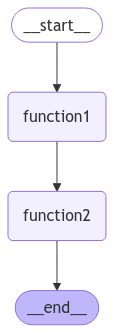

In [8]:
from IPython.display import Image, display

try:
    display(Image(app1.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [9]:
app1.invoke("hi this is sunny ")

'hi this is sunny from first function this is function 3 in between and savita from second function'

In [10]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")
llm.invoke("hi").content

/Users/tejaswidasari/Desktop/langgraph_end_to_end/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'Hello! How can I assist you today?'

In [11]:
def function1(input):
    llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")
    response=llm.invoke(input).content
    return response
    

In [12]:
def function2(input):
    upper_case=input.upper()
    return upper_case

In [13]:
from langgraph.graph import Graph
workflow2=Graph()

In [14]:
workflow2.add_node("llm",function1)

In [15]:
workflow2.add_node("upper_string",function2)

In [16]:
workflow2.add_edge("llm","upper_string")

In [17]:
workflow2.set_entry_point("llm")
workflow2.set_finish_point("upper_string")

In [18]:
app2=workflow2.compile()

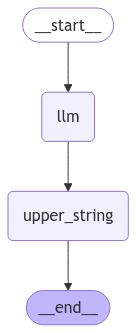

In [19]:
from IPython.display import Image, display

try:
    display(Image(app2.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [20]:
app2.invoke("what is a name of first indian prime minister?")

'JAWAHARLAL NEHRU'

In [21]:
def function3(input):
    token=input.split()
    token_number=len(token)
    token_number=f"total token number is {token_number}"
    return token_number

In [22]:
workflow3=Graph()
workflow3.add_node("llm",function1)
workflow3.add_node("token_counter",function3)
workflow3.add_edge("llm","token_counter")
workflow3.set_entry_point("llm")
workflow3.set_finish_point("token_counter")
app3=workflow3.compile()

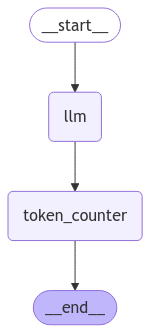

In [23]:
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [24]:
app3.invoke("what is a name of first indian prime minister?")

'total token number is 2'

In [25]:
app3.invoke("what is genai explain in detail?")

'total token number is 449'

adding RAG pipeline to our langgraph workflow

In [26]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [27]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")

In [28]:
llm.invoke("hi").content

'Hello! How can I help you today?'

In [32]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [34]:
loader=DirectoryLoader("./data",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [35]:
db = Chroma.from_documents(new_docs, embeddings)

retriever = db.as_retriever(search_kwargs={"k": 3})

In [36]:
query = "what is meta llama3?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

/var/folders/yb/tddnxctj6ns2__b62rd17vvw0000gn/T/ipykernel_61072/1985905.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


{'source': 'data/llama3.txt'}
Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in
page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': 'data/llama3.txt'}
page_content='by Meta AI starting in February 2023.[2][3] The latest version is Llama 3 released in April' metadata={'source': 'data/llama3.txt'}
page_content='Llama 2, Meta AI started releasing instruction fine-tuned versions alongside foundation models.[7]' metadata={'source': 'data/llama3.txt'}


In [37]:
def function_1(AgentState):
    
    message=AgentState["messages"]
    
    question=message[-1]
    
    complete_prompt="Your task is to provide only the brief answer based on the user query. \
        Don't include too much reasoning. Following is the user query: " + question
    
    response = llm.invoke(complete_prompt)
    
    AgentState['messages'].append(response.content) # appending LLM call response to the AgentState
    
    #print(AgentState)
    
    return AgentState

In [38]:
AgentState={}

In [39]:
AgentState["messages"]=[]

In [40]:
AgentState

{'messages': []}

In [41]:
AgentState["messages"].append("hi, how are you?")

In [42]:
AgentState

{'messages': ['hi, how are you?']}

In [43]:

AgentState["messages"].append("hi, what you doing?")

In [44]:
AgentState

{'messages': ['hi, how are you?', 'hi, what you doing?']}

In [45]:
def function_2(AgentState):
    messages = AgentState['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

In [46]:
from langgraph.graph import Graph
workflow4 = Graph()
workflow4.add_node("LLM", function_1)
workflow4.add_node("RAGtool", function_2)
workflow4.add_edge('LLM', 'RAGtool')
workflow4.set_entry_point("LLM")
workflow4.set_finish_point("RAGtool")
app4 = workflow4.compile()

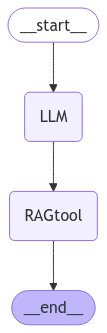

In [47]:
from IPython.display import Image, display

try:
    display(Image(app4.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [48]:
inputs = {"messages": ["Tell me about llama3 model"]}

In [50]:
for output in app4.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'LLM':
---
{'messages': ['Tell me about llama3 model', 'LLaMA is a large language model developed by Meta.', 'Yes']}

---

Output from node 'RAGtool':
---
Llama 3 is a large language model developed by Meta AI. It has been compared favorably against other large language models, such as GPT-3 and Claude, in most benchmarks. The 8B parameter version of Llama 3 has been described as being "surprisingly capable" given its size.

---



In [52]:
loader2=DirectoryLoader("./data2",glob="./*.txt",loader_cls=TextLoader)
docs2=loader2.load()

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs2 = text_splitter.split_documents(documents=docs2)
doc_strings2 = [doc.page_content for doc in new_docs2]

In [53]:
db2 = Chroma.from_documents(new_docs2, embeddings)
retriever2 = db2.as_retriever(search_kwargs={"k": 3})

In [54]:
query = "Tell me about India's Industrial Growth?"
docs = retriever2.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': 'data2/indian_econoy.txt'}
India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a
page_content='India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a' metadata={'source': 'data2/indian_econoy.txt'}
page_content='India’s strong export sectors—including textiles, IT services, and automotive manufacturing—had' metadata={'source': 'data2/indian_econoy.txt'}
page_content='India’s last eight years of GDP (hypothetical data):' metadata={'source': 'data2/indian_econoy.txt'}


In [56]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate

In [57]:
class AgentState(TypedDict):
    # The 'messages' field should be a sequence of strings, and we annotate it with 'operator.add'
    # This implies we might want to "add" new messages to the sequence later
    messages: Annotated[Sequence[BaseMessage], operator.add]

Putting It All Together:

The line messages: Annotated[Sequence[BaseMessage], operator.add] defines a field messages that:

Must be a sequence (like a list or tuple) of BaseMessage objects. Has the additional annotation operator.add, which suggests that this sequence is intended to support addition (i.e., concatenation of multiple sequences of messages).

messages: Annotated[Sequence[BaseMessage], operator.add]

"messages": [BaseMessage("Hello!", "Alice"), BaseMessage("Hi!", "Bob")]

In [58]:
from pydantic import BaseModel , Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [59]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [60]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [61]:
def function_1(state):
    message=state["messages"]
    question=message[-1]
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [India, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain =  prompt | llm | parser
    
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

In [62]:
template="""
    Your task is to classify the given user query into one of the following categories: [Indian economy, Not Related]. 
    Only respond with the category name and nothing else.

    User query: "Tell me about India's Industrial Growth"
    The output should be formatted as a JSON instance that conforms to the JSON schema below.

    As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
    the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

    Here is the output schema:
    ```
    {"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
        """

In [65]:
state={"messages": ["Tell me about taj mahal"]}

In [66]:
function_1(state)

Tell me about taj mahal
Topic='India' Reasoning='The user query is about the Taj Mahal, which is located in India.'


{'messages': ['India']}

In [67]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'India' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [68]:
def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question
    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    print(prompt)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

In [69]:
def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

In [70]:
AgentState

__main__.AgentState

In [71]:
from langgraph.graph import StateGraph,END

workflow5 = StateGraph(AgentState) ### StateGraph with AgentState


workflow5.add_node("agent", function_1)

workflow5.add_node("RAG", function_2)

workflow5.add_node("LLM", function_3)


workflow5.set_entry_point("agent")

workflow5.add_conditional_edges(
    "agent",
    
    
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

workflow5.add_edge("RAG",END)


workflow5.add_edge("LLM",END)


app5=workflow5.compile()

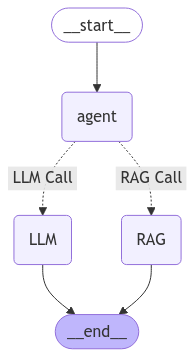

In [72]:
from IPython.display import Image, display

try:
    display(Image(app5.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [73]:
inputs = {"messages": ["Tell me about India's Industrial Growth"]}
output = app5.invoke(inputs)
output

Tell me about India's Industrial Growth
Topic='India' Reasoning="The user query is about India's Industrial Growth."
-> Router ->
India
-> Calling RAG ->
Tell me about India's Industrial Growth
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]


{'messages': ["Tell me about India's Industrial Growth",
  'India',
  "India's industrial growth has outpaced expectations."]}

In [74]:
inputs = {"messages": ["who is president of USA"]}
output = app5.invoke(inputs)
output

who is president of USA
Topic='Not Related' Reasoning='The user query is about the president of the USA, which is not related to India.'
-> Router ->
Not Related
-> Calling LLM ->


{'messages': ['who is president of USA', 'Not Related', 'Joe Biden']}